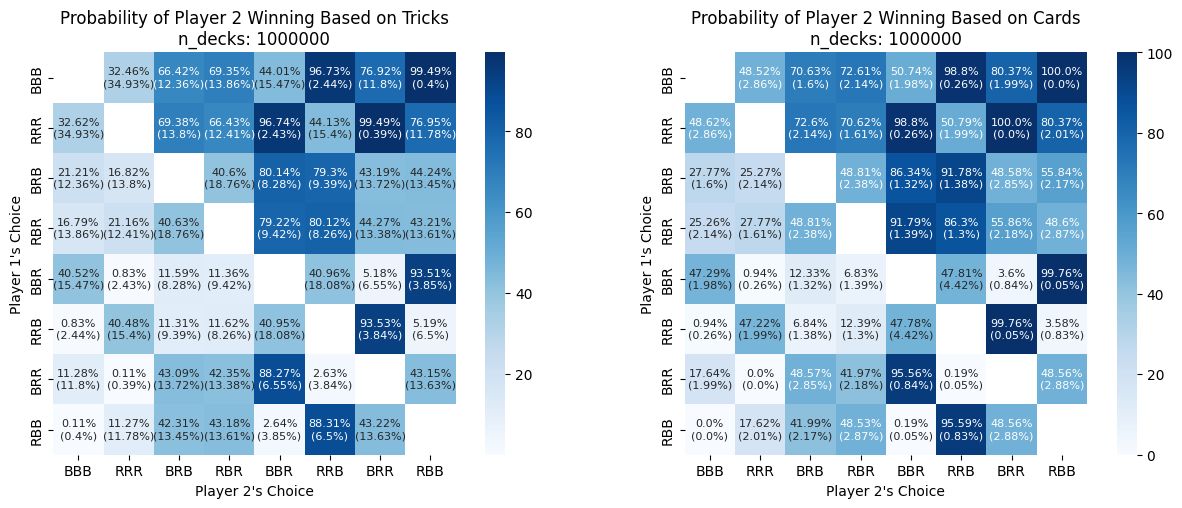

In [17]:
from src.datagen import sample_decks
from src.processing import simulate
from src.visualize import visualize

decks = sample_decks(1000000, 'data/test_decks.npy')
visualize(simulate(decks), 'test_heatmaps')